In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import pickle as pkl

import pims
import trackpy as tp

import uncertainties as unt
import uncertainties.unumpy as unp

from pylab import rcParams
import scipy.signal as sg
import matplotlib.animation as manimation

rcParams['figure.figsize'] = (7, 7)

In [164]:
# Constantes

b = unt.ufloat(6.17e-4, 0.03e-4) * 1333.2239 / 100 # Constante - Pa * m
n_0 = unt.ufloat(1.89E-05, 0.1e-5) # Viscosidade do ar - Kg / (m * s) 
g = unt.ufloat(9.7864, 0.0005) # Aceleração da gravidade - m / s²
dens = unt.ufloat(0.8474, 0.0009) * 1000 # Densidade do óleo - kg / m³
dens_ar = unt.ufloat(1.184, 0.03) # Densidade do ar - kg / m³
q_e = unt.ufloat(1.60E-19, 9.80E-28) # Carga elementar - C
p = unt.ufloat(93645.646736, 53.328956) # Pressão atmosférica - Pa
d = unt.ufloat(4.5, 0.02) * 1e-3 # Distância entre as placas - m
T = unt.ufloat(25, 1) # Temperatura - C

In [165]:
base_path = "~/data/lab6/"

seg1 = {"V": unt.ufloat(45, 3), "cal": (1.05e-3 / 480) * 10, "folder": "seg1"}
se2 = {"V": unt.ufloat(45, 3), "cal": (1.05e-3 / 480) * 20, "folder": "se2"}
se3 = {"V": unt.ufloat(45, 3), "cal": (1.05e-3 / 480) * 5, "folder": "se3"}
ter110v = {"V": unt.ufloat(110, 3), "cal": (1.75e-3 / 480) * 10, "folder": "ter110v"}
ter144v = {"V": unt.ufloat(144, 3), "cal": (1.75e-3 / 480) * 10, "folder": "ter140v"}
ter148v = {"V": unt.ufloat(148, 3), "cal": (1.75e-3 / 480) * 10, "folder": "ter148v"}

proc_folders = [seg1, se2, se3, ter110v, ter144v, ter148v]
proc_folders = [seg1, se2, se3, ter110v, ter144v, ter148v]


In [166]:
def get_trajectories(data_folder):
    
    frames = pims.ImageSequence(data_folder + "*.jpg", as_grey=True)
    f = tp.batch(frames, 19, minmass=1000, preprocess=False,
                 filter_before=False, filter_after=False, percentile=99)    
    
    t = tp.link_df(f, 25, memory=3)
    
    t1 = tp.filter_stubs(t, 10)
    return t1

In [167]:
def get_subtrajectories(trajectories):
    
    t1 = trajectories
    
    particle_list = np.unique(trajectories.particle)
    particle_subtrajs = []

    for particle in particle_list:
        traj = t1[t1.particle == particle]

        max_points = sg.argrelmax(np.array(traj.y))[0]
        min_points = sg.argrelmin(np.array(traj.y))[0]
        extrema = np.concatenate((min_points, max_points))
        extrema.sort()

        n = len(extrema) - 1
        N = len(traj)

        lst = []
        if len(extrema) > 0:
            if extrema[0] != 0:
                ind1 = 0
                ind2 = extrema[0]
                sub_traj = traj[ind1:ind2]
                lst.append(sub_traj)

            for i in range(n):
                ind1 = extrema[i]
                ind2 = extrema[i + 1]
                sub_traj = traj[ind1:ind2]
                lst.append(sub_traj)

            if extrema[-1] != N:
                ind1 = extrema[-1]
                ind2 = N
                sub_traj = traj[ind1:ind2]
                lst.append(sub_traj)

            particle_subtrajs.append(lst)
            
    return particle_subtrajs

In [168]:
def get_velocities(particle_subtrajs):
    
    particle_list = []
    
    for p in particle_subtrajs:
        subindo_list = []
        descendo_list = []
        for s in p:
            if len(s) > 2:
                v = (s.iloc[-1].y - s.iloc[0].y) / (s.iloc[-1].frame - s.iloc[0].frame)
                if v > 0:
                    subindo_list.append(v)
                else:
                    descendo_list.append(v)
        if len(subindo_list) > 1 and len(descendo_list) > 1:
            particle_list.append([subindo_list, descendo_list])
    return particle_list

In [169]:
def get_variables(particle_list, V, cal):
    cal = unt.ufloat(cal, cal * 0.05)

    raios = []
    cargas = []

    for part in particle_list:

        v_s = -np.mean(part[0])
        s_v_s = np.std(part[0])
        v_d = np.mean(part[1])
        s_v_d = np.std(part[1])

        v_s = unt.ufloat(v_s, s_v_s) * cal
        v_d = unt.ufloat(v_d, s_v_d) * cal

        a = -b / (2 * p)    
        f1 = (b ** 2) / (4 * p ** 2)
        f2 = 9 * n_0 * (v_d - v_s)
        f3 = (4 * g) * (dens - dens_ar)  
        if (f1 + (f2 / f3) > 0):
            f4 = unp.sqrt(f1 + (f2 / f3))    
            a += f4 # Raio da gota - m
            raios.append(a)

            # Corrigir a viscosidade do ar pelo raio da gota
            n = n_0 * (1 + b / (p * a)) ** -1 # Viscosidade corrigida - Kg / (m * s)
            q = -3 * np.pi * n * a * d * (v_s + v_d) / V # Carga - C
            cargas.append(q)
    return {"raios": raios, "cargas": cargas}

In [170]:
for proc_folder in proc_folders:
    print("processando {}".format(proc_folder))
    data_folder = os.path.expanduser(base_path + proc_folder["folder"] + "/")
    V = proc_folder["V"]
    cal = proc_folder["cal"]
    
    t = get_trajectories(data_folder)
    st = get_subtrajectories(t)
    if st is not None:
        vel = get_velocities(st)
        if vel is not None:
            var = get_variables(vel, V, cal)
    
            out = {"trajectory": t, "subtrajectories": st, "velocity_list": vel, "variables": var}


            output_path = os.path.expanduser(base_path + proc_folder["folder"] + ".pkl")
            with open(output_path, "bw") as fid:
                pkl.dump(out, fid)

Frame 605: 17 features


KeyboardInterrupt: 

### fazer um filminho

In [16]:
data_folder = os.path.expanduser("~/data/lab6/se2/")
frames = pims.ImageSequence(data_folder + "*.jpg", as_grey=True)

In [37]:
        n = 313
        f = tp.locate(frames[n], 19, minmass=1000, preprocess=False,
                     filter_before=False, filter_after=False, percentile=99)  
        
        tp.annotate(f, frames[n]);
        plt.savefig("1")
        

Frame 300: 21 trajectories present


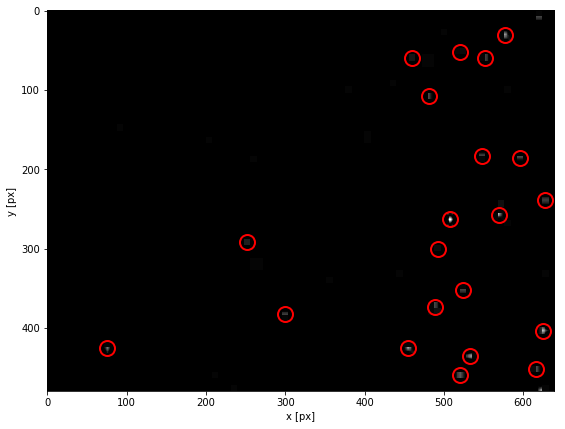

In [66]:
        fig, ax = plt.subplots()
        n = 301
        ff = tp.batch(frames[300:n], 19, minmass=1000, preprocess=False,
                     filter_before=False, filter_after=False, percentile=99) 
        t = tp.link_df(ff, 25, memory=3)
        tp.plot_traj(t, ax=ax)
        
        f = tp.locate(frames[n], 19, minmass=1000, preprocess=False,
                     filter_before=False, filter_after=False, percentile=99) 
        tp.annotate(f, frames[n], ax=ax);
        plt.show()

### opa

In [159]:
path = data_folder = os.path.expanduser("~/data/lab6/se2.pkl")
with open(path, "rb") as fid:
    out = pkl.load(fid)

In [144]:
out.keys()

dict_keys(['trajectory', 'subtrajectories', 'velocity_list', 'variables'])

In [145]:
subtraj = out["subtrajectories"]
vellist = get_velocities(subtraj)
variables = get_variables(vellist, unt.ufloat(45, 3), (1.05e-3 / 480) * 20)

cargas_raw = variables["cargas"]
cargas = []
for c in cargas_raw:
    cargas.append(c.n)
cargas = np.array(cargas) / q_e.n

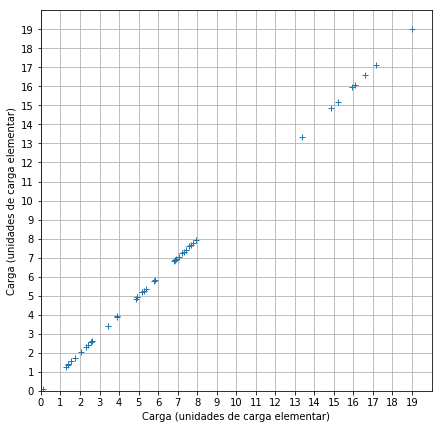

In [162]:
plt.plot(cargas, cargas, '+')
plt.ylim((0, 20))
plt.xlim((0, 20))

#plt.hist(cargas, bins=61, range=(0, 20))
plt.xticks(np.arange(20))
plt.yticks(np.arange(20))
#plt.ylabel("Quantidade de partículas")
plt.ylabel("Carga (unidades de carga elementar)")
plt.xlabel("Carga (unidades de carga elementar)")
plt.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots()

a = []
for key, grp in t1.groupby('particle'):
    a.append(grp.y.diff())
    plt.plot(grp.frame, np.abs(grp.y.diff()), 'k.', alpha=0.1)

plt.ylim((-1, 10))
plt.xlabel("frames")
plt.ylabel("pixels")
plt.title("diferença entre posição em y relativo ao frame sucessivo")
plt.grid()
        
plt.show()

In [ ]:
im = tp.imsd(t1, 1, 1, max_lagtime=200)

fig, ax = plt.subplots()
ax.plot(im.index, np.sqrt(im), '-k', alpha=0.4)  # black lines, semitransparent
plt.title("Deslocamento das trajetorias (%s particulas)" % (im.shape[1]))
plt.ylabel("($\sqrt{\Delta x^2}$) da partícula em pixels")
plt.xlabel("Frames")
plt.show()